In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import time

train_path = "./new_train/new_train/"
val_path = "./new_val_in/new_val_in/"

### Create Dataset Class

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data

In [3]:
train_dataset = ArgoverseDataset(data_path = train_path)
val_dataset = ArgoverseDataset(data_path = val_path)
device = 'cuda'

### Create Dataloader

In [4]:
batch_sz = 32

def extract_car_ind(tid, track_id):
    for i, idx in enumerate(track_id, 0):
        if tid == idx[0][0]:
            return i

def my_collate(batch):
    inp = [numpy.dstack([scene['p_in'][extract_car_ind(scene['agent_id'], scene['track_id'])], scene['v_in'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    out = [numpy.dstack([scene['p_out'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    inp = torch.Tensor(inp)
    out = torch.Tensor(out)
    return [inp, out]

def my_collate_val(batch):
    inp = [numpy.dstack([scene['p_in'][extract_car_ind(scene['agent_id'], scene['track_id'])], scene['v_in'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    inp = torch.Tensor(inp)
    return inp

In [5]:
tr_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate_val, num_workers = 0)

### Create Models

In [6]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        
        self.fc1 = nn.Linear(2, 128)
        self.bn1 = nn.BatchNorm2d(19)
        self.conv1 = nn.Conv2d(19, 512, 1)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 30, 1)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.conv1(x)
        x = self.fc2(x)
        x = F.log_softmax(self.bn2(x), dim = 1)
        x = self.conv2(x)
        x = self.fc3(x)
        return x

In [7]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        self.fc1 = nn.Linear(2, 64)
        self.bn1 = nn.BatchNorm2d(19)
        self.fc2 = nn.Linear(64, 256)
        self.conv1 = nn.Conv2d(19, 512, 1)
        self.fc3 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm2d(512)
        self.fc4 = nn.Linear(128, 64)
        self.conv2 = nn.Conv2d(512, 128, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 30, 1)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.log_softmax(self.bn1(x), dim = 1)
        x = self.fc2(x)
        x = self.conv1(x)
        x = self.fc3(x)
        x = F.log_softmax(self.bn2(x), dim = 1)
        x = self.fc4(x)
        x = self.conv2(x)
        x = F.log_softmax(self.bn3(x), dim = 1)
        x = self.conv3(x)
        x = self.fc5(x)
        return x

In [8]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        
        self.fc1 = nn.Linear(2, 256)
        self.bn1 = nn.BatchNorm2d(19)
        self.fc2 = nn.Linear(256, 512)
        self.conv1 = nn.Conv2d(19, 1024, 1)
        self.fc3 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm2d(1024)
        self.fc4 = nn.Linear(256, 128)
        self.conv2 = nn.Conv2d(1024, 512, 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 30, 1)
        self.fc5 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.log_softmax(self.bn1(x), dim = 1)
        x = self.fc2(x)
        x = self.conv1(x)
        x = self.fc3(x)
        x = F.log_softmax(self.bn2(x), dim = 1)
        x = self.fc4(x)
        x = self.conv2(x)
        x = F.log_softmax(self.bn3(x), dim = 1)
        x = self.conv3(x)
        x = self.fc5(x)
        return x

In [9]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        
        self.fc1 = nn.Linear(2, 4)
        self.bn1 = nn.BatchNorm2d(19)
        self.fc2 = nn.Linear(4, 8)
        self.conv1 = nn.Conv2d(19, 64, 1)
        self.fc3 = nn.Linear(8, 4)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc4 = nn.Linear(4, 2)
        self.conv2 = nn.Conv2d(64, 48, 1)
        self.bn3 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 30, 1)
        self.fc5 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.log_softmax(self.bn1(x), dim = 1)
        x = self.fc2(x)
        x = self.conv1(x)
        x = self.fc3(x)
        x = F.log_softmax(self.bn2(x), dim = 1)
        x = self.fc4(x)
        x = self.conv2(x)
        x = F.log_softmax(self.bn3(x), dim = 1)
        x = self.conv3(x)
        x = self.fc5(x)
        return x

In [10]:
class Model5(nn.Module):
    def __init__(self):
        super(Model5, self).__init__()
        
        self.fc1 = nn.Linear(2, 32)
        self.bn1 = nn.BatchNorm2d(19)
        self.conv1 = nn.Conv2d(19, 128, 1)
        self.fc2 = nn.Linear(32, 128)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc3 = nn.Linear(128, 256)
        self.conv2 = nn.Conv2d(128, 512, 1)
        self.fc4 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm2d(512)
        self.ln = nn.InstanceNorm2d(512, affine = True)
        self.conv3 = nn.Conv2d(512, 256, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc5 = nn.Linear(128, 64)
        self.conv4 = nn.Conv2d(256, 128, 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.fc6 = nn.Linear(64, 32)
        self.conv5 = nn.Conv2d(128, 30, 1)
        self.fc7 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.log_softmax(self.bn1(x), dim = 1)
        x = self.conv1(x)
        x = self.fc2(x)
        x = F.log_softmax(self.bn2(x), dim = 1)
        x = self.fc3(x)
        x = self.conv2(x)
        x = self.fc4(x)
        x = F.log_softmax(self.bn3(x), dim = 1)
        x = F.log_softmax(self.ln(x), dim = 1)
        x = self.conv3(x)
        x = F.log_softmax(self.bn4(x), dim = 1)
        x = self.fc5(x)
        x = self.conv4(x)
        x = F.log_softmax(self.bn5(x), dim = 1)
        x = self.fc6(x)
        x = self.conv5(x)
        x = self.fc7(x)
        return x

In [11]:
def start_pos(x):
    starts = []
    for i in range(x.shape[0]):
        start_x = x[i][0][0][0].item()
        start_y = x[i][0][1][0].item()
        starts += [(start_x, start_y)]
        for j in range(19):
            x[i][j][0][0] -= start_x
            x[i][j][1][0] -= start_y
    return x, starts

def end_pos(x, starts):
    for i in range(x.shape[0]):
        for j in range(30):
            x[i][j][0][0] += starts[i][0]
            x[i][j][1][0] += starts[i][1]
    return x

In [12]:
class Model6(nn.Module):
    def __init__(self):
        super(Model6, self).__init__()
        
        self.fc1 = nn.Linear(2, 64)
        self.bn1 = nn.BatchNorm2d(19)
        self.fc2 = nn.Linear(64, 256)
        self.conv1 = nn.Conv2d(19, 512, 1)
        self.fc3 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm2d(512)
        self.fc4 = nn.Linear(128, 64)
        self.conv2 = nn.Conv2d(512, 128, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 30, 1)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x, starts = start_pos(x)
        x = self.fc1(x)
        x = F.log_softmax(self.bn1(x), dim = 1)
        x = self.fc2(x)
        x = self.conv1(x)
        x = self.fc3(x)
        x = F.log_softmax(self.bn2(x), dim = 1)
        x = self.fc4(x)
        x = self.conv2(x)
        x = F.log_softmax(self.bn3(x), dim = 1)
        x = self.conv3(x)
        x = self.fc5(x)
        return end_pos(x, starts)

In [13]:
class Model7(nn.Module):
    def __init__(self):
        super(Model7, self).__init__()
        
        self.fc1 = nn.Linear(2, 64)
        self.bn1 = nn.BatchNorm2d(19)
        self.fc2 = nn.Linear(64, 256)
        self.conv1 = nn.Conv2d(19, 512, 1)
        self.fc3 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm2d(512)
        self.ln = nn.InstanceNorm2d(512, affine = True)
        self.fc4 = nn.Linear(128, 64)
        self.conv2 = nn.Conv2d(512, 128, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 30, 1)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x, starts = start_pos(x)
        x = self.fc1(x)
        x = F.log_softmax(self.bn1(x), dim = 1)
        x = self.fc2(x)
        x = self.conv1(x)
        x = self.fc3(x)
        x = F.log_softmax(self.ln(x), dim = 1)
        x = F.log_softmax(self.bn2(x), dim = 1)        
        x = self.fc4(x)
        x = self.conv2(x)
        x = F.log_softmax(self.bn3(x), dim = 1)
        x = self.conv3(x)
        x = self.fc5(x)
        return end_pos(x, starts)

### Check Model Parameter Sizes

In [25]:
net1 = Model1().to(device)
net2 = Model2().to(device)
net3 = Model3().to(device)
net4 = Model4().to(device)
net5 = Model5().to(device)
net6 = Model6().to(device)
net7 = Model7().to(device)
nets = [net1, net2, net3, net4, net5, net6, net7]

In [26]:
for n in range(len(nets)):
    print(f'Model {n + 1}: {sum(p.numel() for p in nets[n].parameters())} parameters')

Model 1: 35397 parameters
Model 2: 139141 parameters
Model 3: 860485 parameters
Model 4: 6233 parameters
Model 5: 320421 parameters
Model 6: 139141 parameters
Model 7: 140165 parameters


### Train Model 1

In [27]:
optimizer = optim.RMSprop(net1.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)
e = 10
p = len(tr_loader) // 100
l1 = []
l_mini1 = []

net1.train()
for epoch in range(e):
    t = time.time()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net1(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini1 += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
        if i == 5 * p - 1:
            break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    print(f'Time taken: {round(time.time() - t, 1)} seconds\n')
    l1 += [total_loss / (i + 1)]
print('Finished Training')

[1,    64] loss 1274.458
[1,   128] loss 944.316
[1,   192] loss 869.256
[1,   256] loss 732.370
[1,   320] loss 399.375
End of epoch 1   loss 843.9548499822616
Time taken: 7.2 seconds

[2,    64] loss 133.433
[2,   128] loss 95.761
[2,   192] loss 113.793
[2,   256] loss 95.246
[2,   320] loss 94.737
End of epoch 2   loss 106.59392399191856
Time taken: 7.1 seconds

[3,    64] loss 92.571
[3,   128] loss 84.346
[3,   192] loss 107.423
[3,   256] loss 88.814
[3,   320] loss 92.089
End of epoch 3   loss 93.04851183593273
Time taken: 7.4 seconds

[4,    64] loss 89.184
[4,   128] loss 82.941
[4,   192] loss 105.224
[4,   256] loss 86.965
[4,   320] loss 91.150
End of epoch 4   loss 91.09296379983425
Time taken: 7.3 seconds

[5,    64] loss 87.945
[5,   128] loss 82.274
[5,   192] loss 104.403
[5,   256] loss 86.004
[5,   320] loss 90.825
End of epoch 5   loss 90.29057918787002
Time taken: 7.2 seconds

[6,    64] loss 87.094
[6,   128] loss 81.847
[6,   192] loss 103.862
[6,   256] loss 85

### Train Model 2

In [28]:
optimizer = optim.RMSprop(net2.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)
e = 10
p = len(tr_loader) // 100
l2 = []
l_mini2 = []

net2.train()
for epoch in range(e):
    t = time.time()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net2(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini2 += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
        if i == 5 * p - 1:
            break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    print(f'Time taken: {round(time.time() - t, 1)} seconds\n')
    l2 += [total_loss / (i + 1)]
print('Finished Training')

[1,    64] loss 1626.334
[1,   128] loss 840.093
[1,   192] loss 709.096
[1,   256] loss 570.385
[1,   320] loss 427.437
End of epoch 1   loss 834.6689496040344
Time taken: 9.9 seconds

[2,    64] loss 299.257
[2,   128] loss 189.418
[2,   192] loss 148.543
[2,   256] loss 113.828
[2,   320] loss 108.022
End of epoch 2   loss 171.81375475525857
Time taken: 9.8 seconds

[3,    64] loss 104.097
[3,   128] loss 91.388
[3,   192] loss 118.332
[3,   256] loss 92.797
[3,   320] loss 101.657
End of epoch 3   loss 101.65447365045547
Time taken: 9.8 seconds

[4,    64] loss 95.061
[4,   128] loss 86.728
[4,   192] loss 111.714
[4,   256] loss 86.853
[4,   320] loss 93.842
End of epoch 4   loss 94.83965955972671
Time taken: 9.9 seconds

[5,    64] loss 93.098
[5,   128] loss 87.520
[5,   192] loss 105.030
[5,   256] loss 84.168
[5,   320] loss 92.092
End of epoch 5   loss 92.38166580796242
Time taken: 9.7 seconds

[6,    64] loss 91.267
[6,   128] loss 82.256
[6,   192] loss 100.239
[6,   256] l

### Train Model 3

In [29]:
optimizer = optim.RMSprop(net3.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)
e = 10
p = len(tr_loader) // 100
l3 = []
l_mini3 = []

net3.train()
for epoch in range(e):
    t = time.time()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net3(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini3 += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
        if i == 5 * p - 1:
            break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    print(f'Time taken: {round(time.time() - t, 1)} seconds\n')
    l3 += [total_loss / (i + 1)]
print('Finished Training')

[1,    64] loss 1347.318
[1,   128] loss 1118.440
[1,   192] loss 1044.956
[1,   256] loss 764.908
[1,   320] loss 331.744
End of epoch 1   loss 921.473194861412
Time taken: 22.3 seconds

[2,    64] loss 137.543
[2,   128] loss 134.731
[2,   192] loss 128.375
[2,   256] loss 103.220
[2,   320] loss 106.488
End of epoch 2   loss 122.07165979146957
Time taken: 22.4 seconds

[3,    64] loss 106.423
[3,   128] loss 87.634
[3,   192] loss 118.675
[3,   256] loss 97.144
[3,   320] loss 102.182
End of epoch 3   loss 102.41161149442196
Time taken: 22.9 seconds

[4,    64] loss 98.695
[4,   128] loss 90.381
[4,   192] loss 118.696
[4,   256] loss 95.836
[4,   320] loss 120.719
End of epoch 4   loss 104.86540139317512
Time taken: 22.7 seconds

[5,    64] loss 100.380
[5,   128] loss 91.791
[5,   192] loss 115.291
[5,   256] loss 92.323
[5,   320] loss 105.576
End of epoch 5   loss 101.07206051945687
Time taken: 22.8 seconds

[6,    64] loss 95.435
[6,   128] loss 85.652
[6,   192] loss 116.393
[

### Train Model 4

In [30]:
optimizer = optim.RMSprop(net4.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)
e = 10
p = len(tr_loader) // 100
l4 = []
l_mini4 = []

net4.train()
for epoch in range(e):
    t = time.time()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net4(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini4 += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
        if i == 5 * p - 1:
            break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    print(f'Time taken: {round(time.time() - t, 1)} seconds\n')
    l4 += [total_loss / (i + 1)]
print('Finished Training')

[1,    64] loss 2163.531
[1,   128] loss 2118.366
[1,   192] loss 2067.477
[1,   256] loss 1995.516
[1,   320] loss 1966.325
End of epoch 1   loss 2062.2430908203123
Time taken: 6.9 seconds

[2,    64] loss 1917.185
[2,   128] loss 1831.453
[2,   192] loss 1744.483
[2,   256] loss 1639.169
[2,   320] loss 1573.171
End of epoch 2   loss 1741.092279815674
Time taken: 6.9 seconds

[3,    64] loss 1484.230
[3,   128] loss 1352.037
[3,   192] loss 1186.641
[3,   256] loss 1023.875
[3,   320] loss 900.064
End of epoch 3   loss 1189.3693107604981
Time taken: 6.7 seconds

[4,    64] loss 765.659
[4,   128] loss 600.710
[4,   192] loss 481.011
[4,   256] loss 409.145
[4,   320] loss 386.555
End of epoch 4   loss 528.6159436225892
Time taken: 6.7 seconds

[5,    64] loss 370.447
[5,   128] loss 346.348
[5,   192] loss 336.697
[5,   256] loss 328.083
[5,   320] loss 323.939
End of epoch 5   loss 341.10267119407655
Time taken: 6.7 seconds

[6,    64] loss 315.594
[6,   128] loss 300.684
[6,   192]

### Train Model 5

In [31]:
optimizer = optim.RMSprop(net5.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)
e = 10
p = len(tr_loader) // 100
l5 = []
l_mini5 = []

net5.train()
for epoch in range(e):
    t = time.time()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net5(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini5 += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
        if i == 5 * p - 1:
            break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    print(f'Time taken: {round(time.time() - t, 1)} seconds\n')
    l5 += [total_loss / (i + 1)]
print('Finished Training')

[1,    64] loss 1314.174
[1,   128] loss 810.850
[1,   192] loss 525.907
[1,   256] loss 253.275
[1,   320] loss 144.906
End of epoch 1   loss 609.8224933385849
Time taken: 13.5 seconds

[2,    64] loss 127.905
[2,   128] loss 98.495
[2,   192] loss 125.487
[2,   256] loss 97.425
[2,   320] loss 104.602
End of epoch 2   loss 110.78285193443298
Time taken: 13.1 seconds

[3,    64] loss 95.854
[3,   128] loss 86.643
[3,   192] loss 114.925
[3,   256] loss 88.871
[3,   320] loss 96.287
End of epoch 3   loss 96.51618015170098
Time taken: 13.2 seconds

[4,    64] loss 90.139
[4,   128] loss 82.708
[4,   192] loss 105.453
[4,   256] loss 86.018
[4,   320] loss 91.994
End of epoch 4   loss 91.26244538724423
Time taken: 12.9 seconds

[5,    64] loss 86.399
[5,   128] loss 81.446
[5,   192] loss 100.901
[5,   256] loss 83.862
[5,   320] loss 90.443
End of epoch 5   loss 88.61027286946774
Time taken: 13.0 seconds

[6,    64] loss 85.686
[6,   128] loss 81.313
[6,   192] loss 101.582
[6,   256] l

### Train Model 6

In [32]:
optimizer = optim.RMSprop(net6.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)
e = 10
p = len(tr_loader) // 100
l6 = []
l_mini6 = []

net6.train()
for epoch in range(e):
    t = time.time()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net6(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini6 += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
        if i == 5 * p - 1:
            break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    print(f'Time taken: {round(time.time() - t, 1)} seconds\n')
    l6 += [total_loss / (i + 1)]
print('Finished Training')

[1,    64] loss 11.337
[1,   128] loss 4.223
[1,   192] loss 3.891
[1,   256] loss 3.666
[1,   320] loss 3.526
End of epoch 1   loss 5.328680254518986
Time taken: 123.7 seconds

[2,    64] loss 3.518
[2,   128] loss 3.637
[2,   192] loss 3.713
[2,   256] loss 3.542
[2,   320] loss 3.486
End of epoch 2   loss 3.579163920879364
Time taken: 124.5 seconds

[3,    64] loss 3.475
[3,   128] loss 3.587
[3,   192] loss 3.678
[3,   256] loss 3.540
[3,   320] loss 3.458
End of epoch 3   loss 3.547667499259114
Time taken: 124.8 seconds

[4,    64] loss 3.454
[4,   128] loss 3.589
[4,   192] loss 3.659
[4,   256] loss 3.501
[4,   320] loss 3.442
End of epoch 4   loss 3.528887889534235
Time taken: 125.7 seconds

[5,    64] loss 3.437
[5,   128] loss 3.550
[5,   192] loss 3.653
[5,   256] loss 3.491
[5,   320] loss 3.423
End of epoch 5   loss 3.511071582511067
Time taken: 125.7 seconds

[6,    64] loss 3.433
[6,   128] loss 3.540
[6,   192] loss 3.611
[6,   256] loss 3.462
[6,   320] loss 3.416
End 

### Train Model 7

In [35]:
optimizer = optim.RMSprop(net7.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)
e = 10
p = len(tr_loader) // 100
l7 = []
l_mini7 = []

net7.train()
for epoch in range(e):
    t = time.time()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net7(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini7 += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
        if i == 5 * p - 1:
            break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    print(f'Time taken: {round(time.time() - t, 1)} seconds\n')
    l7 += [total_loss / (i + 1)]
print('Finished Training')

[1,    64] loss 8.042
[1,   128] loss 4.678
[1,   192] loss 4.057
[1,   256] loss 4.074
[1,   320] loss 3.692
End of epoch 1   loss 4.908330384641886
Time taken: 122.5 seconds

[2,    64] loss 3.729
[2,   128] loss 3.942
[2,   192] loss 3.773
[2,   256] loss 3.670
[2,   320] loss 3.448
End of epoch 2   loss 3.71228665933013
Time taken: 122.4 seconds

[3,    64] loss 3.523
[3,   128] loss 3.626
[3,   192] loss 3.626
[3,   256] loss 3.496
[3,   320] loss 3.375
End of epoch 3   loss 3.5292492773383857
Time taken: 122.4 seconds

[4,    64] loss 3.435
[4,   128] loss 3.468
[4,   192] loss 3.554
[4,   256] loss 3.432
[4,   320] loss 3.340
End of epoch 4   loss 3.445733347162604
Time taken: 122.5 seconds

[5,    64] loss 3.391
[5,   128] loss 3.471
[5,   192] loss 3.523
[5,   256] loss 3.400
[5,   320] loss 3.323
End of epoch 5   loss 3.4218274284154178
Time taken: 122.4 seconds

[6,    64] loss 3.371
[6,   128] loss 3.442
[6,   192] loss 3.502
[6,   256] loss 3.369
[6,   320] loss 3.307
End 

### Best Working Design

In [41]:
e = 10
p = len(tr_loader) // 100
l7 = []
l_mini7 = []

net7 = Model7().to(device)
optimizer = optim.RMSprop(net7.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)

for epoch in range(e):
    net7.train()
    training = True
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        if training:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            try:
                outputs = net7(inputs)
            except RuntimeError:
                print('!')
                continue
            loss = torch.sqrt(criterion(outputs, targets))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_loss += loss.item()
            if i % p == p - 1:
                l_mini7 += [running_loss / p]
                print('[%d, %5d] loss %.3f' %
                      (epoch + 1, i + 1, running_loss / p))
                running_loss = 0.0
            if i == 10 * p - 1:
                net7.eval()
                training = False
                val_loss = 0.0
        else:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            with torch.no_grad():
                outputs = net7(inputs)
            loss = torch.sqrt(criterion(outputs, targets))
            val_loss += loss.item()
             
            if i == 11 * p - 1:
                break
            
    print(f'End of epoch {epoch + 1} ... loss {total_loss / (p * 10)} ... val loss {val_loss / p}')
    l7 += [total_loss / (i + 1)]
print('Finished Training')

[1,    64] loss 10.143
[1,   128] loss 4.722
[1,   192] loss 4.101
[1,   256] loss 4.126
[1,   320] loss 3.808
[1,   384] loss 3.984
[1,   448] loss 3.747
[1,   512] loss 3.507
[1,   576] loss 3.484
[1,   640] loss 3.889
End of epoch 1 ... loss 4.55096649043262 ... val loss 3.49470192566514
[2,    64] loss 3.740
[2,   128] loss 3.670
[2,   192] loss 3.653
[2,   256] loss 3.614
[2,   320] loss 3.399
[2,   384] loss 3.621
[2,   448] loss 3.523
[2,   512] loss 3.365
[2,   576] loss 3.387
[2,   640] loss 3.520
End of epoch 2 ... loss 3.549294275045395 ... val loss 3.044815968722105
[3,    64] loss 3.412
[3,   128] loss 3.464
[3,   192] loss 3.561
[3,   256] loss 3.438
[3,   320] loss 3.350
[3,   384] loss 3.579
[3,   448] loss 3.428
[3,   512] loss 3.287
[3,   576] loss 3.360
[3,   640] loss 3.364
End of epoch 3 ... loss 3.424168625660241 ... val loss 3.0018725022673607
[4,    64] loss 3.372
[4,   128] loss 3.493
[4,   192] loss 3.531
[4,   256] loss 3.386
[4,   320] loss 3.323
[4,   384] 

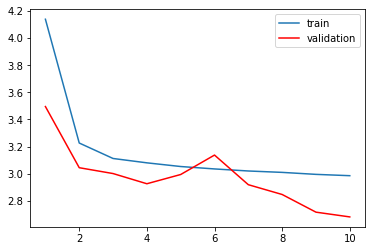

In [46]:
plt.plot(range(1, 11), l7, label = 'train')
plt.plot(range(1, 11), [3.495, 3.045, 3.002, 2.927, 2.995, 3.138, 2.920, 2.848, 2.718, 2.683], c = 'red', label = 'validation')
_ = plt.legend()

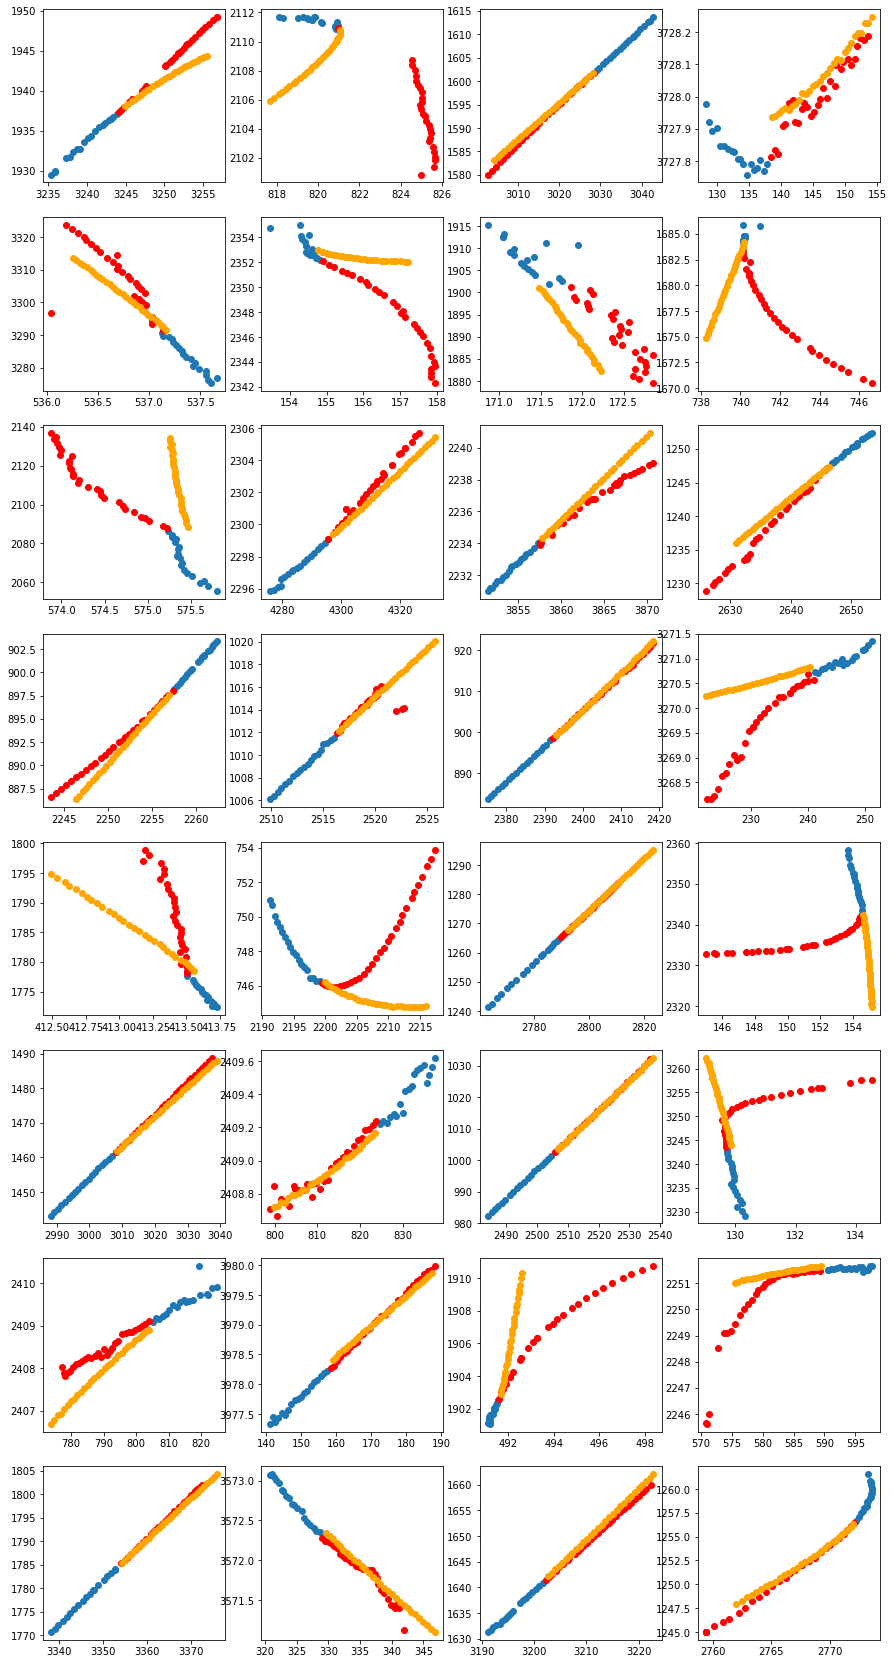

In [52]:
for i, data in enumerate(tr_loader, 0):
    if i != 2:
        continue
    else:
        inputs, targets = data
        break
with torch.no_grad():
    net7.eval()
    out = net7(inp.to(device))
fig, axes = plt.subplots(8, 4, figsize = (15, 30))
for i in range(8):
    for j in range(4):
        x_in = [inp[4 * i + j][k][0][0].item() for k in range(19)]
        y_in = [inp[4 * i + j][k][1][0].item() for k in range(19)]
        x_true_out = [target[4 * i + j][k][0].item() for k in range(30)]
        y_true_out = [target[4 * i + j][k][1].item() for k in range(30)]
        x_out = [out[4 * i + j][k][0].item() for k in range(30)]
        y_out = [out[4 * i + j][k][1].item() for k in range(30)]

        axes[i, j].scatter(x_in, y_in)
        axes[i, j].scatter(x_true_out, y_true_out, c = 'red')
        axes[i, j].scatter(x_out, y_out, c = 'orange')